

# Where should I open a Storage Facility?

The goal of this exercise "how US demographic trends influence the self-storage market and that PS can use this to make better investment decisions" &#x1F680;

Essentially, we are trying to understand what factors lead to consumer needing a additional space to store belongings. &#x1F9F3;&#x200D;


#### Approach
My approach is to break this down in 2 parts: 




#### Metrics
Based on economic and additional context provided, I thought of the below metrics that could help us understand how these facrtors influence the self-storage market locations


| Metric | Definition | Usage | Source | 
| --- | --- | --- | --- |
| Population Per sqft | ratio of number of people per sqft | We want to look at this metric in 2 ways <br> First, by markets where there are currently storage spaces available.  | There are 2 sources for this metric <br> 1. We can use the <i>Area</i> field in the 'property locations.csv' field <br> 2. Census data to pull population of those locations 
| Migration Flow | This is number of people migrating in and out of counties and states | Breaking this down by city, county and states will help us understand relationship between number of people migrating and storage spaces available  | Source: [IRS GOV](https://www.irs.gov/statistics/soi-tax-stats-migration-data-2019-2020) 
| Median Value of Housing Unit | in dollars, median value of a housing unit | | Census.gov |


For the purpose of this exercise, scope is limited to evaluating difference in metrics with a Property Locations in a County vs time series of metrics

Equation we are formulating is 

$$ P(\text{Storage Location} | \text{Metrics}) = \frac{P(\text{Metrics} | \text{Storage Location}) \cdot P(\text{Metrics})}{P(\text{Storage Location})} $$


In [2]:
import censusdata 
import pandas as pd 
import urllib.request
import addfips as af   
import re 
import os
import zipfile
import numpy as np
import requests
import json
import prettytable
import matplotlib.pyplot as plt
import seaborn as sns
from uszipcode import SearchEngine
import json

pd.options.display.float_format = '{:.2f}'.format

af = af.AddFIPS()

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### County level Census Data


<span style="font-size: medium;">
There are 3 datasets that this analysis will look at

1) County-level business patterns and types of businesses in a county 
2) Census level Data such as Housing Income, Median House Prices, Age Distribution 
3) Population Data: Birth Rates, Death Rates, Migration,  
</span>

<span style="font-size: medium;">

Keeping this below code as markdown for now, but it is the code to download the data from the census website.

~~~python
url = "https://www2.census.gov/programs-surveys/cbp/datasets/2021/cbp21co.zip"

r = requests.get(url)
zip_path = "cbp21co.zip"

with open(zip_path, "wb") as f:
    f.write(r.content)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall()

~~~
</span>

##### Read in Downloaded Census Data and create a FIPs column for county and state

In [5]:
county_business_patterns = pd.read_csv('data/cbp21co.txt',sep=",")
county_business_patterns['fipscty'] = county_business_patterns['fipscty'].astype(str).str.zfill(3)
county_business_patterns['fipstate'] = county_business_patterns['fipstate'].astype(str).str.zfill(2)
county_business_patterns['fips'] = county_business_patterns['fipstate'] + county_business_patterns['fipscty']
county_business_patterns.head()

,fipstate,fipscty,naics,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,...,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4,fips
0,01,001,------,G,11216,G,97944,G,424826,924,...,31,8,N,N,N,N,N,N,N,01001
1,01,001,11----,G,78,G,1325,G,5107,10,...,N,N,N,N,N,N,N,N,N,01001
2,01,001,113///,G,68,G,1213,G,4563,7,...,N,N,N,N,N,N,N,N,N,01001
3,01,001,1133//,G,68,G,1213,G,4563,7,...,N,N,N,N,N,N,N,N,N,01001
4,01,001,11331/,G,68,G,1213,G,4563,7,...,N,N,N,N,N,N,N,N,N,01001


#### Distinct counts of 3,190 in county_business_patterns

Find level of granularity of this dataset

In [6]:
# Find the level of aggregation for the data
county_business_patterns.nunique()

fipstate        51
fipscty        325
naics         1991
emp_nf           3
emp          15825
qp1_nf           3
qp1          56675
ap_nf            3
ap          108085
est           3425
n<5           2535
n5_9          1276
n10_19        1049
n20_49         913
n50_99         466
n100_249       331
n250_499       159
n500_999        96
n1000           81
n1000_1         44
n1000_2         36
n1000_3         29
n1000_4         21
fips          3190
dtype: int64

Each FIPS code is unique to a county, checking the dataset for 1 county, it seems it is further cut by types of businesses.

While there may be valuable information there for a different analysis, it is not what will be used for this analysis.

In [7]:
county_business_patterns.columns   

Index(['fipstate', 'fipscty', 'naics', 'emp_nf', 'emp', 'qp1_nf', 'qp1',
       'ap_nf', 'ap', 'est', 'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99',
       'n100_249', 'n250_499', 'n500_999', 'n1000', 'n1000_1', 'n1000_2',
       'n1000_3', 'n1000_4', 'fips'],
      dtype='object')

In [8]:
county_business_patterns.drop(columns=['fipstate', 'fipscty','qp1','qp1_nf', 'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99','n100_249', 'n250_499', 'n500_999', 'n1000', 'n1000_1', 'n1000_2','n1000_3', 'n1000_4'],inplace=True)
values_to_keep = ['G','H']
county_business_patterns = county_business_patterns[county_business_patterns['emp_nf'].isin(values_to_keep) & (county_business_patterns['ap_nf'].isin(values_to_keep))]
county_business_patterns.drop(columns=['emp_nf','ap_nf'],inplace=True)
county_business_patterns.drop_duplicates(inplace=True)
print(county_business_patterns.shape)
county_business_patterns.head()

(658072, 5)


,naics,emp,ap,est,fips
0,------,11216,424826,924,01001
1,11----,78,5107,10,01001
2,113///,68,4563,7,01001
3,1133//,68,4563,7,01001
4,11331/,68,4563,7,01001


NOTE: Noise Flag definitions (fields ending in _NF) are:

        G       0 to < 2% noise (low noise)
        H       2 to < 5% noise (medium noise)
	    J	>= 5% noise (high noise)

      Flag definition for Establishment by Employment Size Class fields (N<5, N5_9, etc.):
	
	      N	Not available or not comparable

#### Check for duplicates of State FIPS and County FIPS

In [9]:
check_county_duplicates = county_business_patterns.groupby(['fips']).size().reset_index(name='counts')
if (check_county_duplicates['counts'] > 1).any():
    print("There are duplicate counties in the dataset")
else:
    print("There are no duplicate counties in the dataset")


There are duplicate counties in the dataset


Map County Names to County FIPS

In [10]:
naics_codes_mapping = pd.read_csv('data/2020_gaz_counties_national.txt',sep=",",encoding='latin-1')
naics_codes_mapping.head()

,NAICS,DESCRIPTION
0,------,Total for all sectors
1,11----,"Agriculture, Forestry, Fishing and Hunting"
2,113///,Forestry and Logging
3,1131//,Timber Tract Operations
4,11311/,Timber Tract Operations


In [11]:
# Merge the two datasets
types_of_businesses_in_counties = pd.merge(county_business_patterns, naics_codes_mapping, how='left', left_on='naics', right_on=['NAICS'])
types_of_businesses_in_counties = types_of_businesses_in_counties[['fips','naics','DESCRIPTION','emp','ap']]
types_of_businesses_in_counties.head()

,fips,naics,DESCRIPTION,emp,ap
0,01001,------,Total for all sectors,11216,424826
1,01001,11----,"Agriculture, Forestry, Fishing and Hunting",78,5107
2,01001,113///,Forestry and Logging,68,4563
3,01001,1133//,Logging,68,4563
4,01001,11331/,Logging,68,4563


In [32]:
types_of_businesses_in_counties.dtypes

fips           object
naics          object
DESCRIPTION    object
emp             int64
ap              int64
dtype: object

In [12]:
county_business_patterns.drop(columns=['naics'],inplace=True)
county_business_patterns.reset_index()
county_business_patterns.drop_duplicates(inplace=True)
print(county_business_patterns.shape)
county_business_patterns.head()

(431094, 4)


,emp,ap,est,fips
0,11216,424826,924,01001
1,78,5107,10,01001
2,68,4563,7,01001
7,87,5144,6,01001
12,138,16713,5,01001


In [13]:
total_sectors = types_of_businesses_in_counties[types_of_businesses_in_counties['DESCRIPTION'] == 'Total for all sectors']
total_sectors.drop(columns=['naics'],inplace=True)
total_sectors.reset_index()
total_sectors.drop_duplicates(inplace=True)
total_sectors.sort_values(by=['fips'],inplace=True)
total_sectors.head()

/tmp/ipykernel_21246/4277654722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sectors.drop(columns=['naics'],inplace=True)
/tmp/ipykernel_21246/4277654722.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sectors.drop_duplicates(inplace=True)
/tmp/ipykernel_21246/4277654722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_sectors.sort_values(by=['fips'],inplace=True)


,fips,DESCRIPTION,emp,ap
0,01001,Total for all sectors,11216,424826
197,01003,Total for all sectors,65335,2723499
766,01005,Total for all sectors,6085,239521
857,01007,Total for all sectors,4008,185469
920,01009,Total for all sectors,6765,257981


In [14]:
county_business_patterns = county_business_patterns.groupby(['fips'])['est'].sum().reset_index()
total_sectors = total_sectors.merge(county_business_patterns, how='left', on='fips')
total_sectors.rename(columns={'est':'total_est'},inplace=True)
total_sectors.head()

,fips,DESCRIPTION,emp,ap,total_est
0,01001,Total for all sectors,11216,424826,3359
1,01003,Total for all sectors,65335,2723499,26483
2,01005,Total for all sectors,6085,239521,1284
3,01007,Total for all sectors,4008,185469,801
4,01009,Total for all sectors,6765,257981,2517


In [15]:
types_of_businesses_in_counties.drop(columns=['naics'],inplace=True)
types_of_businesses_in_counties.drop_duplicates(inplace=True)
types_of_businesses_in_counties.reset_index()
types_of_businesses_in_counties.head()

,fips,DESCRIPTION,emp,ap
0,01001,Total for all sectors,11216,424826
1,01001,"Agriculture, Forestry, Fishing and Hunting",78,5107
2,01001,Forestry and Logging,68,4563
3,01001,Logging,68,4563
6,01001,"Mining, Quarrying, and Oil and Gas Extraction",87,5144


In [16]:
types_of_businesses_in_counties[types_of_businesses_in_counties['DESCRIPTION'].str.contains('Technical Services')].sort_values(by=['ap'],ascending=False).head(10)

,fips,DESCRIPTION,emp,ap
383991,36061,"Professional, Scientific, and Technical Services",324083,52503588
56670,06085,"Professional, Scientific, and Technical Services",160339,34511523
40680,06037,"Professional, Scientific, and Technical Services",308692,33672563
152129,17031,"Professional, Scientific, and Technical Services",249494,30979048
597056,51059,"Professional, Scientific, and Technical Services",233048,28296684
52435,06075,"Professional, Scientific, and Technical Services",126588,25549034
260853,25017,"Professional, Scientific, and Technical Services",146216,24808915
51400,06073,"Professional, Scientific, and Technical Services",172480,24409057
556929,48201,"Professional, Scientific, and Technical Services",174923,18233681
621514,53033,"Professional, Scientific, and Technical Services",133960,17699523


In [17]:
dallas = types_of_businesses_in_counties[types_of_businesses_in_counties['fips'] == '48113']
dallas.sort_values(by=['ap'],ascending=False).head(10)

,fips,DESCRIPTION,emp,ap
546956,48113,Total for all sectors,1506838,110554872
547822,48113,"Professional, Scientific, and Technical Services",142004,16669568
547717,48113,Finance and Insurance,108425,13154118
548019,48113,Health Care and Social Assistance,182912,11177463
547594,48113,Transportation and Warehousing,135786,9001015
547906,48113,Management of Companies and Enterprises,70611,8598450
547911,48113,"Corporate, Subsidiary, and Regional Managing O...",67760,8214209
547662,48113,Information,63193,7661135
547040,48113,Manufacturing,102992,7431312
547315,48113,Wholesale Trade,84101,6682817


From the above analysis we have 2 dataframes

1) ```Total_Sectors``` : Has Annual Payroll, Number of Employers, Number of Establishments in a County
2) ```Types_of_businesses_in_counties```: Has Annual Payroll, Number of Employers by types of businesses operating in a county

For the purpose of this analysis we will keep the scope to just the 1st dataset

## <span style="color: #5F9EA0;">Now we look to explore additional data</span>


### Reading in Storage Locations File

We will use this to match counties with count of storage locations in a given county and explore relationships with metrics we have already pulled 

In [20]:
property_df = pd.read_csv(os.getcwd() + '/data/property locations.csv') 

## We will use the US Zip Code Library to get the county name and state name for each property
search = SearchEngine()

def get_county(zipcode):
    result = search.by_zipcode(str(zipcode))
    if result is not None:
        return result.county
    else:
        return None

with open('data/state_codes.json') as f:
    state_codes = json.load(f)

property_df['state_fips'] = property_df.ST.map(state_codes) 
property_df['county'] = property_df['Zip'].apply(get_county) 
property_df['Rental_Revenue'] = property_df['Rental_Revenue'].str.replace(',', '').astype(int) 
property_df['county_fips'] = property_df.apply(lambda row: af.get_county_fips(row['county'], row['ST']), axis=1)
property_df.head()

,Market,"Owner/Operator, Franchise",ADDRESS,CTY,ST,Zip,Area,Year,Rental_Revenue,state_fips,county,county_fips
0,Albuquerque,Extra Space Storage,1522 Pacheco Street,Santa Fe,NM,87505,73934.00,2000.00,517538,35,Santa Fe County,35049
1,Albuquerque,Extra Space Storage,1909 Golf Course Road SE,Rio Rancho,NM,87124,72836.00,2000.00,509852,35,Sandoval County,35043
2,Albuquerque,Extra Space Storage,3300 Calle Cuervo NW,Albuquerque,NM,87114,80889.00,1998.00,566223,35,Bernalillo County,35001
3,Albuquerque,Extra Space Storage,9831 Montgomery Blvd NE,Albuquerque,NM,87111,62697.00,1997.00,438879,35,Bernalillo County,35001
4,Albuquerque,Extra Space Storage,9221 Eagle Ranch Road NW,Albuquerque,NM,87114,60821.00,1998.00,425747,35,Bernalillo County,35001


In [21]:
property_df['county_fips'].nunique()

326

There are only 326 counties where a storage location exists. Next I will group this data by counting storage locations by county_fips

In [22]:
storage_locations = property_df.groupby(['county_fips'])['Owner/Operator, Franchise'].count().reset_index(name='counts').sort_values(by=['counts'],ascending=False)
storage_locations

,county_fips,counts
12,06037,238
285,48201,147
93,17031,139
51,12011,93
279,48113,93
...,...,...
270,47149,1
269,47105,1
161,29165,1
169,32005,1


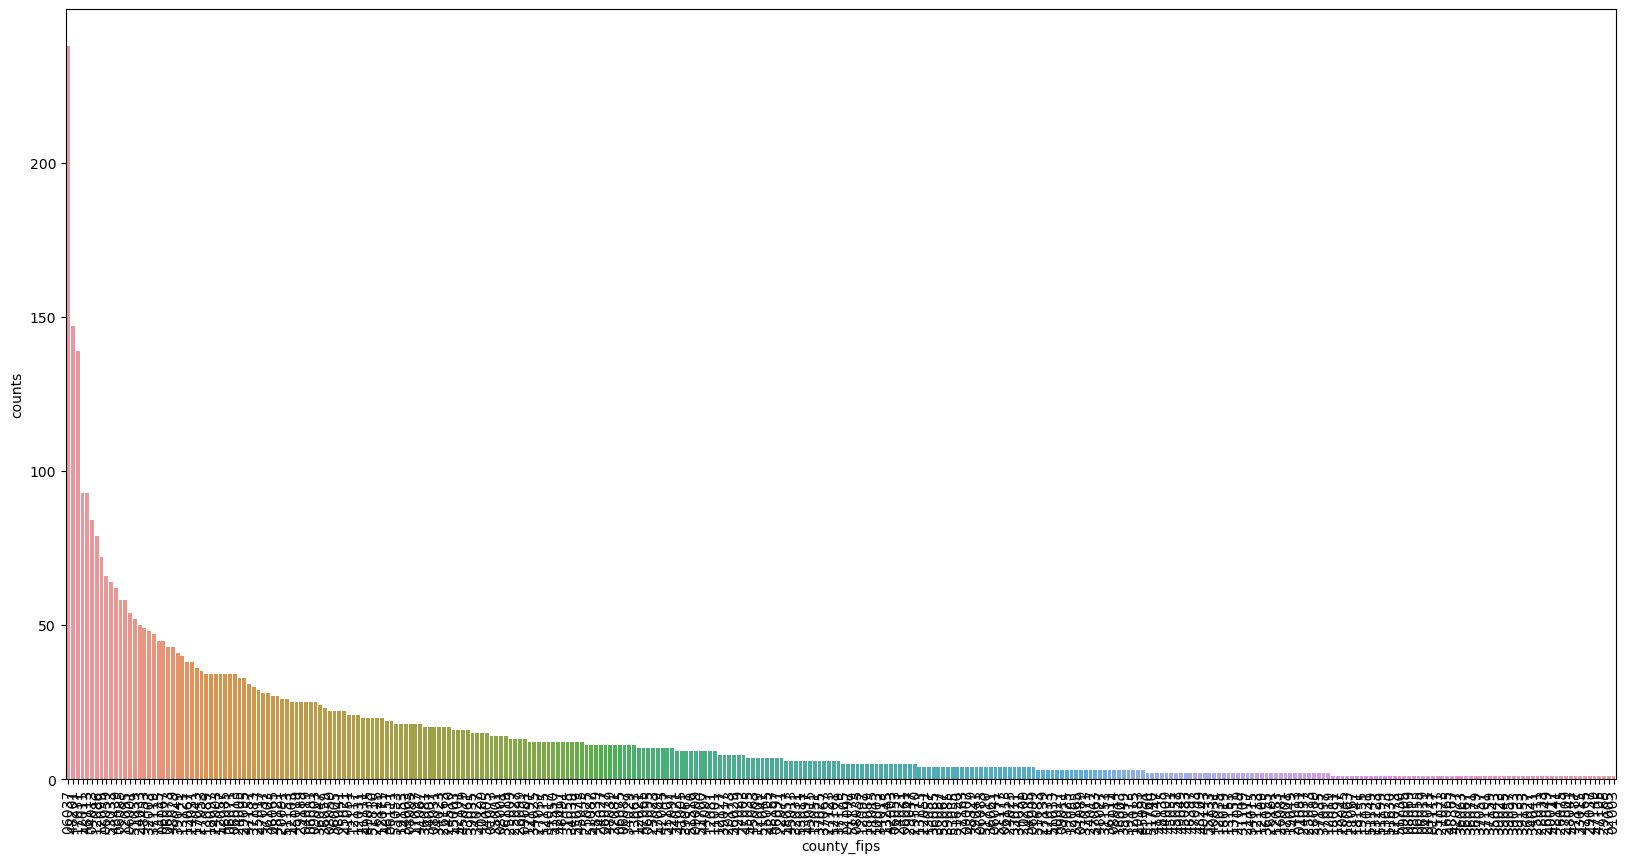

In [23]:
# Plot distribution of storage locations across counties
plt.figure(figsize=(20,10))
sns.barplot(x='county_fips', y='counts', data=storage_locations)
plt.xticks(rotation=90)
plt.show()

### Census API and Data Cleaning

In [24]:
county_census = censusdata.download('acs5', 2021, censusdata.censusgeo([('county', '*')]),
                                   [
                                    'B25077_001E', # Median Value of Housing Unit
                                    'B19013_001E', # Median Household Income
                                    'B01001_003E', # Total_Population Under 5 years Male
                                    'B01001_004E', # Total_Population 5 to 9 years Male
                                    'B01001_005E', # Total_Population 10 to 14 years Male
                                    'B01001_006E', # Estimate Total Population 15 to 17 years Male
                                    'B01001_007E', # Estimate Total Population 18 and 19 years Male
                                    'B01001_008E', # Estimate Total Population 20 years Male
                                    'B01001_009E', # Estimate Total Population 21 years Male
                                    'B01001_010E', # Estimate Total Population 22-24 years Male
                                    'B01001_011E', # Estimate Total Population 25-29 years Male
                                    'B01001_012E', # Estimate Total Population 30-34 years Male
                                    'B07001_001E', # Total Geographic Mobility
                                    'B01003_001E',# Land_Area_in_SqMi
                                    'B01001_001E' # Total_Population
                                    ])


col_names = { 
    'B01001_001E' : 'Total_Population',
    'B25077_001E' : 'Median_Value_Housing_Unit',
    'B01001_003E' : 'age_5_male',
    'B01001_004E' : 'age_5_9_male',
    'B01001_005E' :  'age_10_14_male',
    'B01001_006E' : 'age_15_17_male',
    'B01001_007E' :  'age_18_19_male',
    'B01001_008E' : 'age_20_male',
    'B01001_009E' : 'age_21_male',
    'B01001_010E' : 'age_22_24_male',
    'B01001_011E' : 'age_25_29_male',
    'B01001_012E' : 'age_30_34_male',
    'B19013_001E' : 'Median_Household_Income',
    'B07001_001E' : 'Total Geographic Mobility',
    'B01003_001E' : 'Land_Area_in_SqMi' 	
}



county_census.index.name = 'region'
county_census = county_census.reset_index()
census_df = pd.DataFrame(county_census)
census_df['region'] = census_df['region'].astype(str)
census_df['county_name'] = census_df.region.apply(lambda x: x.split(",")[0]) 
census_df['state_name'] = census_df.region.apply(lambda x: x.split(",")[1:2])
census_df['state_name'] = census_df['state_name'].astype(str).str.extract('\[(.*?)\]', expand=False).str.split(':').str[0].str.strip()
census_df['state_name'] = census_df['state_name'].str.replace("' ","")
census_df['state_name'] = census_df['state_name'].str.strip()
census_df['state_fips'] = census_df['region'].str.extract('state:(\d{2})') 
census_df['state_fips'] = census_df['state_fips'].apply(lambda x: re.sub(r'\D', '', x))
census_df.rename(columns=col_names, inplace=True)
census_df = census_df.drop(columns=['region'],inplace=False)
print('Distinct Count of Counties: ',census_df.county_name.nunique())
census_df['Total_Population'] = census_df['Total_Population'].astype(float)
census_df['Median_Value_Housing_Unit'] = census_df['Median_Value_Housing_Unit'].astype(float)
census_df['Median_Household_Income'] = census_df['Median_Household_Income'].astype(float)
census_df['Land_Area_in_SqMi'] = census_df['Land_Area_in_SqMi'].astype(float)
census_df['Total Geographic Mobility'] = census_df['Total Geographic Mobility'].astype(float)
census_df['Median_Household_Income'] = census_df['Median_Household_Income'].replace(-666666666.0, np.nan)
census_df['Median_Value_Housing_Unit'] = census_df['Median_Value_Housing_Unit'].replace(-666666666.0, np.nan)
census_df['county_fips'] = census_df.apply(lambda row: af.get_county_fips(row['county_name'], row['state_fips']), axis=1)

with open(os.getcwd() + '/data/state_abbreviated.json') as f:
    states_dict = json.load(f) 

census_df['ST'] = census_df['state_name'].map(states_dict)
census_df.set_index(['county_name','state_name'])


print(census_df.shape)
census_df.head()

Distinct Count of Counties:  1956
(3221, 20)


,Median_Value_Housing_Unit,Median_Household_Income,age_5_male,age_5_9_male,age_10_14_male,age_15_17_male,age_18_19_male,age_20_male,age_21_male,age_22_24_male,age_25_29_male,age_30_34_male,Total Geographic Mobility,Land_Area_in_SqMi,Total_Population,county_name,state_name,state_fips,county_fips,ST
0,164900.00,62660.00,1783,1959,1927,1233,559,520,222,1019,1854,1823,57537.00,58239.00,58239.00,Autauga County,Alabama,01,01001,AL
1,226600.00,64346.00,6121,5709,8771,4512,2477,1513,702,3455,6013,6258,225170.00,227131.00,227131.00,Baldwin County,Alabama,01,01003,AL
2,89500.00,36422.00,647,743,755,470,362,380,84,348,1127,1069,25030.00,25259.00,25259.00,Barbour County,Alabama,01,01005,AL
3,102900.00,54277.00,603,646,720,551,284,142,120,369,1125,1029,22143.00,22412.00,22412.00,Bibb County,Alabama,01,01007,AL
4,138100.00,52830.00,1818,1906,2058,1391,616,399,293,1135,1844,1661,58151.00,58884.00,58884.00,Blount County,Alabama,01,01009,AL


In [25]:
census_df['county_fips'].fillna(0, inplace=True)

In [26]:
census_df['county_fips'].nunique()

3220

In [27]:
census_with_storage = census_df.merge(storage_locations, how='left', on='county_fips')
census_with_storage.drop(columns=['Land_Area_in_SqMi','state_fips','ST','state_name'],inplace=True)
census_with_storage

,Median_Value_Housing_Unit,Median_Household_Income,age_5_male,age_5_9_male,age_10_14_male,age_15_17_male,age_18_19_male,age_20_male,age_21_male,age_22_24_male,age_25_29_male,age_30_34_male,Total Geographic Mobility,Total_Population,county_name,county_fips,counts
0,164900.00,62660.00,1783,1959,1927,1233,559,520,222,1019,1854,1823,57537.00,58239.00,Autauga County,01001,NaN
1,226600.00,64346.00,6121,5709,8771,4512,2477,1513,702,3455,6013,6258,225170.00,227131.00,Baldwin County,01003,1.00
2,89500.00,36422.00,647,743,755,470,362,380,84,348,1127,1069,25030.00,25259.00,Barbour County,01005,NaN
3,102900.00,54277.00,603,646,720,551,284,142,120,369,1125,1029,22143.00,22412.00,Bibb County,01007,NaN
4,138100.00,52830.00,1818,1906,2058,1391,616,399,293,1135,1844,1661,58151.00,58884.00,Blount County,01009,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,108700.00,21507.00,1123,1277,1659,1056,718,481,268,1058,1893,1573,NaN,54544.00,Vega Baja Municipio,72145,NaN
3217,123700.00,14942.00,255,165,232,183,0,93,41,207,184,269,NaN,8317.00,Vieques Municipio,72147,NaN
3218,93300.00,20722.00,509,664,682,471,364,173,167,482,732,578,NaN,22341.00,Villalba Municipio,72149,NaN
3219,85800.00,17267.00,559,698,1008,580,409,231,349,437,956,789,NaN,31047.00,Yabucoa Municipio,72151,NaN


In [28]:
census_with_storage['match'] = np.where(census_with_storage['counts'].notnull(), 1,0)
census_with_storage['storage_spaces'] = census_with_storage['counts'].fillna(0)
census_with_storage.drop(columns=['counts'],inplace=True)
print(census_with_storage.nunique())
print(census_with_storage.shape)

Median_Value_Housing_Unit    1747
Median_Household_Income      3104
age_5_male                   1979
age_5_9_male                 2015
age_10_14_male               2101
age_15_17_male               1735
age_18_19_male               1474
age_20_male                  1145
age_21_male                  1122
age_22_24_male               1690
age_25_29_male               2031
age_30_34_male               2010
Total Geographic Mobility    3087
Total_Population             3143
county_name                  1956
county_fips                  3220
match                           2
storage_spaces                 58
dtype: int64
(3221, 18)


In [29]:
census_with_storage.match.value_counts()

0    2895
1     326
Name: match, dtype: int64

### Population Demographics

In [32]:

url = "https://www2.census.gov/programs-surveys/popest/datasets/2020-2022/counties/totals/co-est2022-alldata.csv"

file_name = "co-est2022-alldata.csv"
file_path = os.path.join(os.getcwd(), file_name)

urllib.request.urlretrieve(url, file_path)

if os.path.isfile(file_path):
    print("File downloaded and saved successfully!")
else:
    print("Error: File not found.") 

pop_df = pd.read_csv(file_path, encoding='latin-1', dtype={'STATE':str,'COUNTY':str})

with open(os.getcwd() + '/data/co-est2022_ColNames.json') as f:
    pop_cols = json.load(f) 

pop_df = pop_df.rename(columns=pop_cols)
pop_df = pop_df[pop_df['SUMLEV'] == 50]
pop_df.head()

File downloaded and saved successfully!


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,estimates_base_2020,population_estimate_2020,population_estimate_2021,...,death_rate_2021,death_rate_2022,natural_change_rate_2021,natural_change_rate_2022,international_migration_rate_2021,international_migration_rate_2022,domestic_migration_rate_2021,domestic_migration_rate_2022,net_migration_rate_2021,net_migration_rate_2022
1,50,3,6,01,001,Alabama,Autauga County,58802,58902,59210,...,11.55,11.31,0.20,0.61,0.25,0.45,4.06,8.54,4.32,8.99
2,50,3,6,01,003,Alabama,Baldwin County,231761,233219,239361,...,12.88,11.98,-2.87,-2.05,0.44,1.30,29.49,28.74,29.94,30.04
3,50,3,6,01,005,Alabama,Barbour County,25224,24960,24539,...,15.48,15.11,-4.32,-3.86,0.00,0.16,-12.44,9.87,-12.44,10.03
4,50,3,6,01,007,Alabama,Bibb County,22300,22183,22370,...,14.28,14.47,-3.32,-3.29,0.04,0.09,11.63,-13.57,11.67,-13.48
5,50,3,6,01,009,Alabama,Blount County,59130,59102,59085,...,14.64,14.23,-3.54,-2.87,0.15,0.24,2.37,9.98,2.52,10.22


In [33]:
pop_df.columns

Index(['SUMLEV', 'REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'estimates_base_2020', 'population_estimate_2020',
       'population_estimate_2021', 'population_estimate_2022',
       'population_change_2020', 'population_change_2021',
       'population_change_2022', 'births_2020', 'births_2021', 'births_2022',
       'deaths_2020', 'deaths_2021', 'deaths_2022', 'natural_change_2020',
       'natural_change_2021', 'natural_change_2022',
       'international_migration_2020', 'international_migration_2021',
       'international_migration_2022', 'domestic_migration_2020',
       'domestic_migration_2021', 'domestic_migration_2022',
       'net_migration_2020', 'net_migration_2021', 'net_migration_2022',
       'residual_2020', 'residual_2021', 'residual_2022',
       'group_quarters_estimates_base_2020', 'group_quarters_estimate_2020',
       'group_quarters_estimate_2021', 'group_quarters_estimate_2022',
       'birth_rate_2021', 'birth_rate_2022', 'death_rate_2

In [34]:
pop_df['County_FIPS'] = pop_df.apply(lambda row: af.get_county_fips(row['CTYNAME'], row['STATE']), axis=1)
pop_df.drop(columns=['REGION','DIVISION','STATE','COUNTY','STNAME','CTYNAME','SUMLEV', 
                      'estimates_base_2020', 'population_estimate_2020',
       'population_estimate_2021', 
       'population_change_2020', 'population_change_2021',
       'population_change_2022', 'births_2020', 'births_2021',
       'deaths_2020', 'deaths_2021', 'natural_change_2020',
       'natural_change_2021','international_migration_2020', 'international_migration_2021','domestic_migration_2020','domestic_migration_2021',
       'net_migration_2020', 'net_migration_2021',
       'residual_2020', 'residual_2021', 'residual_2022',
       'group_quarters_estimates_base_2020', 'group_quarters_estimate_2020','group_quarters_estimate_2021','group_quarters_estimate_2022',
       'birth_rate_2021', 'birth_rate_2022',
       'death_rate_2021','death_rate_2022',
       'natural_change_rate_2021','natural_change_rate_2022',
        'international_migration_rate_2021','international_migration_rate_2022',
        'domestic_migration_rate_2021', 'domestic_migration_rate_2022', 
        'net_migration_rate_2021','net_migration_rate_2022'
                     
                     ],inplace=True)
pop_df.head()

,population_estimate_2022,births_2022,deaths_2022,natural_change_2022,international_migration_2022,domestic_migration_2022,net_migration_2022,County_FIPS
1,59759,709,673,36,27,508,535,01001
2,246435,2411,2909,-498,315,6982,7297,01003
3,24706,277,372,-95,4,243,247,01005
4,22005,248,321,-73,2,-301,-299,01007
5,59512,674,844,-170,14,592,606,01009


In [35]:
pop_df.sort_values(by=['population_estimate_2022'],ascending=False,inplace=True)
pop_df

,population_estimate_2022,births_2022,deaths_2022,natural_change_2022,international_migration_2022,domestic_migration_2022,net_migration_2022,County_FIPS
210,9721138,98065,79777,18288,33935,-142953,-109018,06037
626,5109292,55365,49015,6350,18392,-94344,-75952,17031
2669,4780913,64873,34756,30117,37268,-20006,17262,48201
107,4551524,50726,42920,7806,15288,33305,48593,04013
228,3276208,37683,24987,12696,9043,-18647,-9604,06073
...,...,...,...,...,...,...,...,...
1742,372,3,8,-5,0,-5,-5,31117
2699,358,2,1,1,0,14,14,48261
2703,233,2,1,1,0,-26,-26,48269
562,82,1,0,1,0,0,0,15005


In [36]:
print(census_with_storage.columns)
print(total_sectors.columns)
print(pop_df.columns)

Index(['Median_Value_Housing_Unit', 'Median_Household_Income', 'age_5_male',
       'age_5_9_male', 'age_10_14_male', 'age_15_17_male', 'age_18_19_male',
       'age_20_male', 'age_21_male', 'age_22_24_male', 'age_25_29_male',
       'age_30_34_male', 'Total Geographic Mobility', 'Total_Population',
       'county_name', 'county_fips', 'match', 'storage_spaces'],
      dtype='object')
Index(['fips', 'DESCRIPTION', 'emp', 'ap', 'total_est'], dtype='object')
Index(['population_estimate_2022', 'births_2022', 'deaths_2022',
       'natural_change_2022', 'international_migration_2022',
       'domestic_migration_2022', 'net_migration_2022', 'County_FIPS'],
      dtype='object')


In [37]:
# Merge the three datasets
census_with_storage = census_with_storage.merge(total_sectors, how='left', left_on='county_fips',right_on='fips')
census_with_storage = census_with_storage.merge(pop_df, how='left', left_on='county_fips', right_on='County_FIPS')
census_with_storage

,Median_Value_Housing_Unit,Median_Household_Income,age_5_male,age_5_9_male,age_10_14_male,age_15_17_male,age_18_19_male,age_20_male,age_21_male,age_22_24_male,...,ap,total_est,population_estimate_2022,births_2022,deaths_2022,natural_change_2022,international_migration_2022,domestic_migration_2022,net_migration_2022,County_FIPS
0,164900.00,62660.00,1783,1959,1927,1233,559,520,222,1019,...,424826.00,3359.00,59759.00,709.00,673.00,36.00,27.00,508.00,535.00,01001
1,226600.00,64346.00,6121,5709,8771,4512,2477,1513,702,3455,...,2723499.00,26483.00,246435.00,2411.00,2909.00,-498.00,315.00,6982.00,7297.00,01003
2,89500.00,36422.00,647,743,755,470,362,380,84,348,...,239521.00,1284.00,24706.00,277.00,372.00,-95.00,4.00,243.00,247.00,01005
3,102900.00,54277.00,603,646,720,551,284,142,120,369,...,185469.00,801.00,22005.00,248.00,321.00,-73.00,2.00,-301.00,-299.00,01007
4,138100.00,52830.00,1818,1906,2058,1391,616,399,293,1135,...,257981.00,2517.00,59512.00,674.00,844.00,-170.00,14.00,592.00,606.00,01009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3216,108700.00,21507.00,1123,1277,1659,1056,718,481,268,1058,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3217,123700.00,14942.00,255,165,232,183,0,93,41,207,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3218,93300.00,20722.00,509,664,682,471,364,173,167,482,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3219,85800.00,17267.00,559,698,1008,580,409,231,349,437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
print(census_with_storage.County_FIPS.nunique())
print(census_with_storage.fips.nunique())
print(census_with_storage.county_fips.nunique())

3132
3095
3220


In [39]:
census_with_storage.drop(columns=['County_FIPS'],inplace=True)
census_with_storage.reset_index(inplace=True)
census_with_storage.drop(columns=['index'],inplace=True)
census_with_storage.head()

,Median_Value_Housing_Unit,Median_Household_Income,age_5_male,age_5_9_male,age_10_14_male,age_15_17_male,age_18_19_male,age_20_male,age_21_male,age_22_24_male,...,emp,ap,total_est,population_estimate_2022,births_2022,deaths_2022,natural_change_2022,international_migration_2022,domestic_migration_2022,net_migration_2022
0,164900.00,62660.00,1783,1959,1927,1233,559,520,222,1019,...,11216.00,424826.00,3359.00,59759.00,709.00,673.00,36.00,27.00,508.00,535.00
1,226600.00,64346.00,6121,5709,8771,4512,2477,1513,702,3455,...,65335.00,2723499.00,26483.00,246435.00,2411.00,2909.00,-498.00,315.00,6982.00,7297.00
2,89500.00,36422.00,647,743,755,470,362,380,84,348,...,6085.00,239521.00,1284.00,24706.00,277.00,372.00,-95.00,4.00,243.00,247.00
3,102900.00,54277.00,603,646,720,551,284,142,120,369,...,4008.00,185469.00,801.00,22005.00,248.00,321.00,-73.00,2.00,-301.00,-299.00
4,138100.00,52830.00,1818,1906,2058,1391,616,399,293,1135,...,6765.00,257981.00,2517.00,59512.00,674.00,844.00,-170.00,14.00,592.00,606.00


In [40]:
census_with_storage.columns

Index(['Median_Value_Housing_Unit', 'Median_Household_Income', 'age_5_male',
       'age_5_9_male', 'age_10_14_male', 'age_15_17_male', 'age_18_19_male',
       'age_20_male', 'age_21_male', 'age_22_24_male', 'age_25_29_male',
       'age_30_34_male', 'Total Geographic Mobility', 'Total_Population',
       'county_name', 'county_fips', 'match', 'storage_spaces', 'fips',
       'DESCRIPTION', 'emp', 'ap', 'total_est', 'population_estimate_2022',
       'births_2022', 'deaths_2022', 'natural_change_2022',
       'international_migration_2022', 'domestic_migration_2022',
       'net_migration_2022'],
      dtype='object')

In [41]:
modeling_df = census_with_storage[census_with_storage['total_est'].notnull()]
modeling_df.fillna(0,inplace=True)
modeling_df = modeling_df[['fips','county_fips','match','population_estimate_2022','domestic_migration_2022','Total_Population','ap','births_2022','deaths_2022','total_est','international_migration_2022','emp','Median_Household_Income','Median_Value_Housing_Unit','storage_spaces']].sort_values(by=['population_estimate_2022'],ascending=False)
print(modeling_df.shape)
print(modeling_df.county_fips.nunique())
modeling_df.head()

(3095, 15)
3095


/tmp/ipykernel_21246/393714525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeling_df.fillna(0,inplace=True)


,fips,county_fips,match,population_estimate_2022,domestic_migration_2022,Total_Population,ap,births_2022,deaths_2022,total_est,international_migration_2022,emp,Median_Household_Income,Median_Value_Housing_Unit,storage_spaces
205,06037,06037,1,9721138.00,-142953.00,10019635.00,269549588.00,98065.00,79777.00,1410394.00,33935.00,3629082.00,76367.00,647000.00,238.00
611,17031,17031,1,5109292.00,-94344.00,5265398.00,178172447.00,55365.00,49015.00,644126.00,18392.00,2292825.00,72121.00,266800.00,139.00
2624,48201,48201,1,4780913.00,-20006.00,4697957.00,143108258.00,64873.00,34756.00,515311.00,37268.00,1980428.00,65788.00,201200.00,147.00
104,04013,04013,1,4551524.00,33305.00,4367186.00,109245341.00,50726.00,42920.00,492381.00,15288.00,1800495.00,72944.00,304700.00,84.00
223,06073,06073,1,3276208.00,-18647.00,3296317.00,94759926.00,37683.00,24987.00,426927.00,9043.00,1249426.00,88240.00,627200.00,43.00


In [42]:
modeling_df.drop(columns=['fips'],inplace=True)

### Visualize

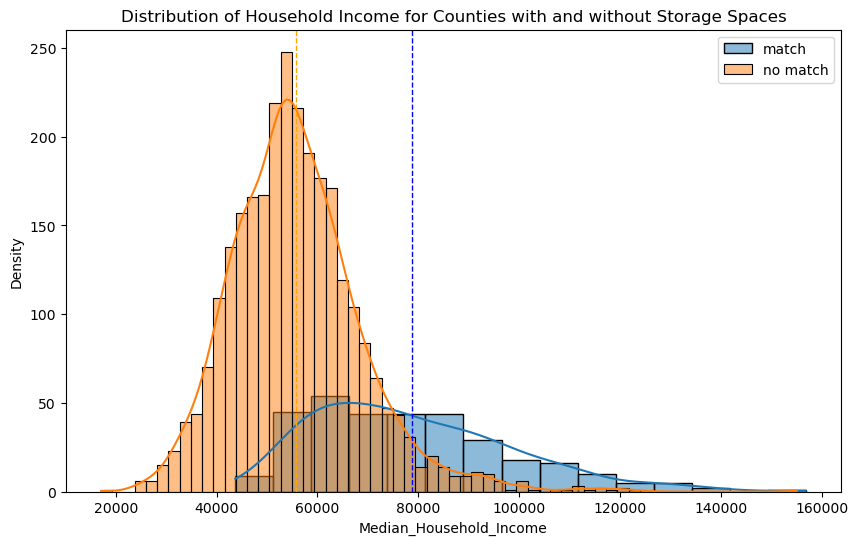

In [43]:
# Create a distribution plot of ap with a condition (match = 1); Create a distribution plot of ap with a condition (match = 0) and see if there is a difference; Plot labels of match and no match on the same plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(modeling_df['Median_Household_Income'][modeling_df['match'] == 1], kde=True, label='match', ax=ax)
sns.histplot(modeling_df['Median_Household_Income'][modeling_df['match'] == 0], kde=True, label='no match', ax=ax)
plt.axvline(modeling_df['Median_Household_Income'][modeling_df['match'] == 1].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(modeling_df['Median_Household_Income'][modeling_df['match'] == 0].mean(), color='orange', linestyle='dashed', linewidth=1)
plt.title('Distribution of Household Income for Counties with and without Storage Spaces')
plt.xlabel('Median_Household_Income')
plt.legend()
plt.ylabel('Density')
plt.show()

From the above chart we see that counties with storage spaces have a higher household income on average ($80,000) than counties without a storage space ($60,000)

In [44]:
int_cols = ['ap','emp','total_est','storage_spaces','births_2022','deaths_2022','domestic_migration_2022','international_migration_2022','Total_Population','Median_Household_Income','Median_Value_Housing_Unit']
modeling_df[int_cols] = modeling_df[int_cols].astype(int)

In [45]:
print(modeling_df['ap'][modeling_df['match'] == 1].describe(),modeling_df['ap'][modeling_df['match'] == 0].describe())

count         326.00
mean     18463139.94
std      32597148.77
min        372499.00
25%       3153432.00
50%       8965680.00
75%      19677995.50
max     304080571.00
Name: ap, dtype: float64 count       2769.00
mean      641145.10
std      1257006.25
min         1017.00
25%        76675.00
50%       226795.00
75%       606091.00
max     19607301.00
Name: ap, dtype: float64


In [46]:
modeling_df.drop(columns=['population_estimate_2022'],inplace=True)

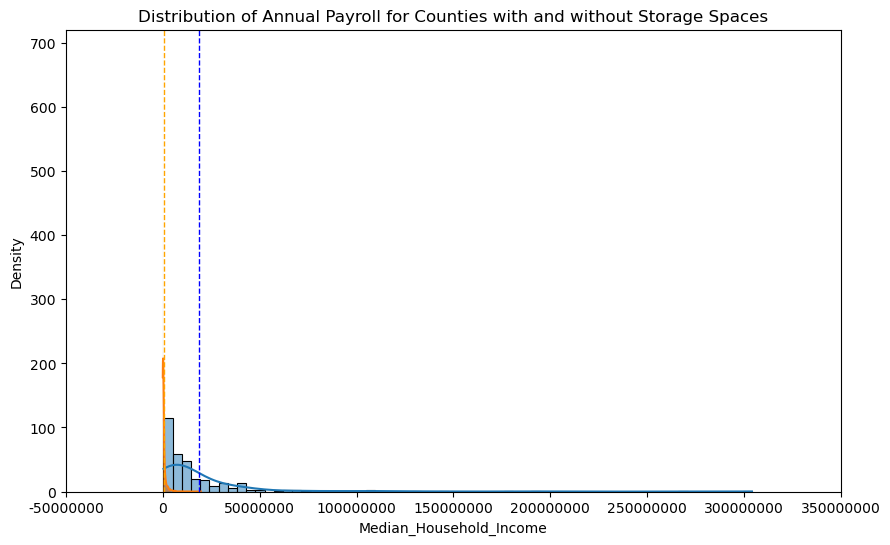

In [47]:
# Create a distribution plot of ap with a condition (match = 1); Create a distribution plot of ap with a condition (match = 0) and see if there is a difference; Plot labels of match and no match on the same plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(modeling_df['ap'][modeling_df['match'] == 1], kde=True, label='match', ax=ax)
sns.histplot(modeling_df['ap'][modeling_df['match'] == 0], kde=True, label='no match', ax=ax)
plt.axvline(modeling_df['ap'][modeling_df['match'] == 1].mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(modeling_df['ap'][modeling_df['match'] == 0].mean(), color='orange', linestyle='dashed', linewidth=1)
plt.xticks(ticks=plt.xticks()[0], labels=[int(tick) for tick in plt.xticks()[0]])
plt.title('Distribution of Annual Payroll for Counties with and without Storage Spaces')
plt.xlabel('Median_Household_Income')
plt.ylabel('Density')
plt.show()

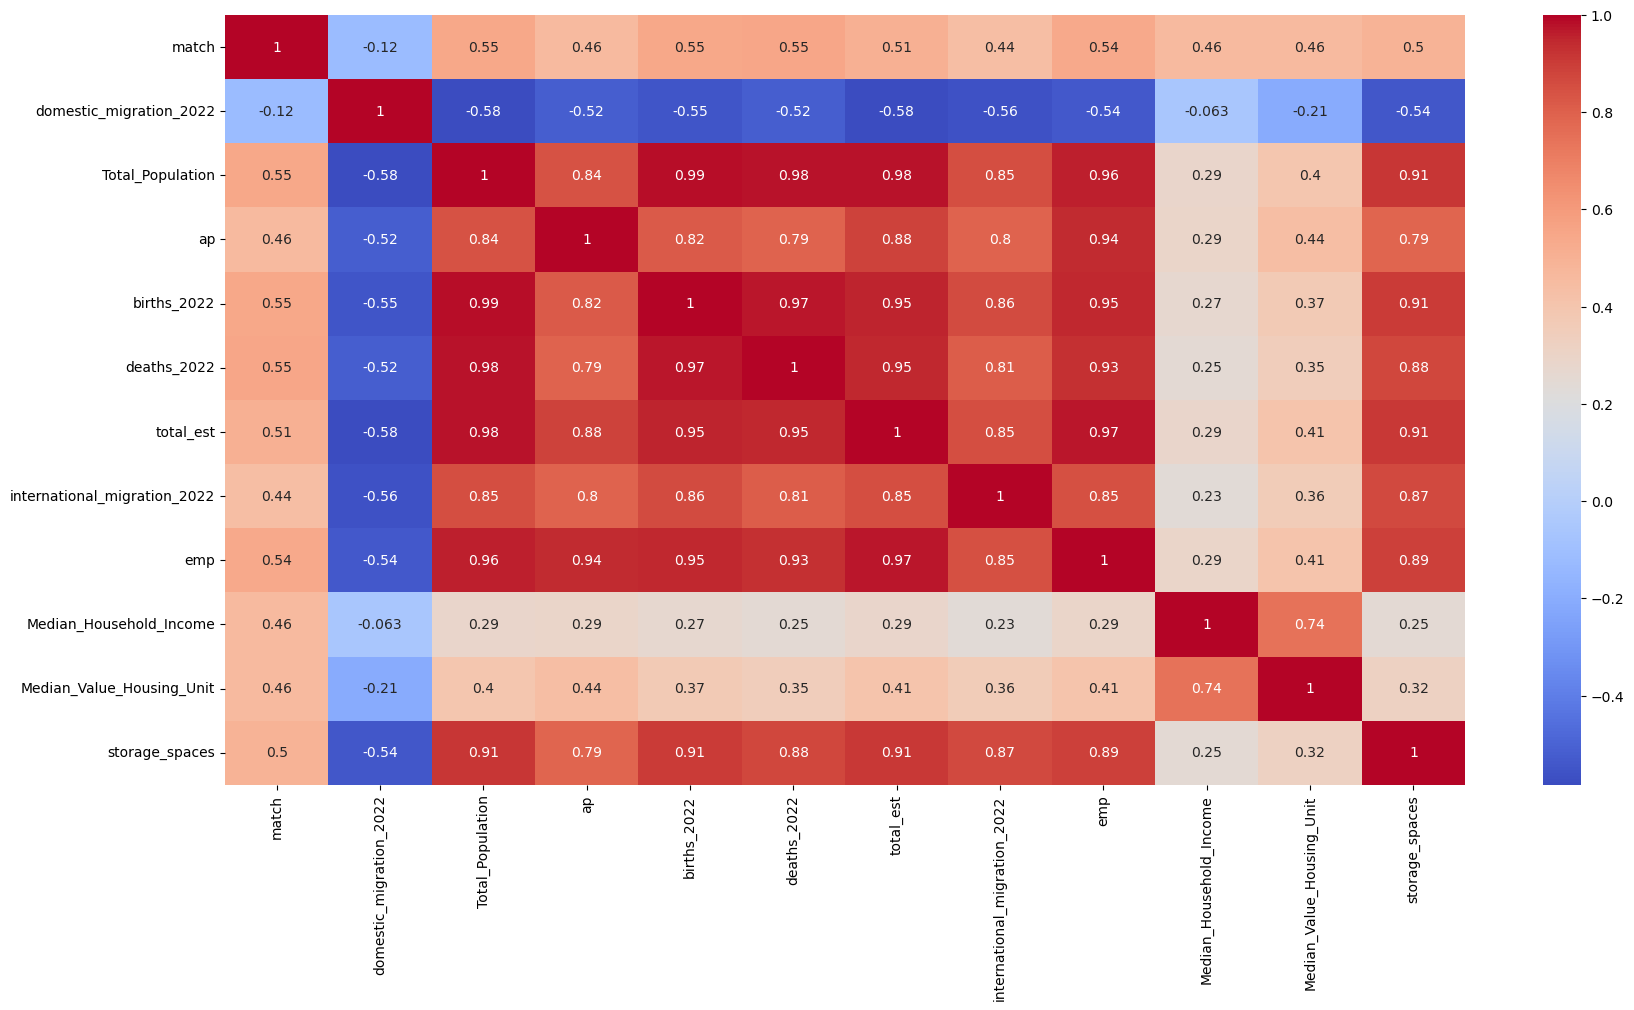

In [48]:
corr = modeling_df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

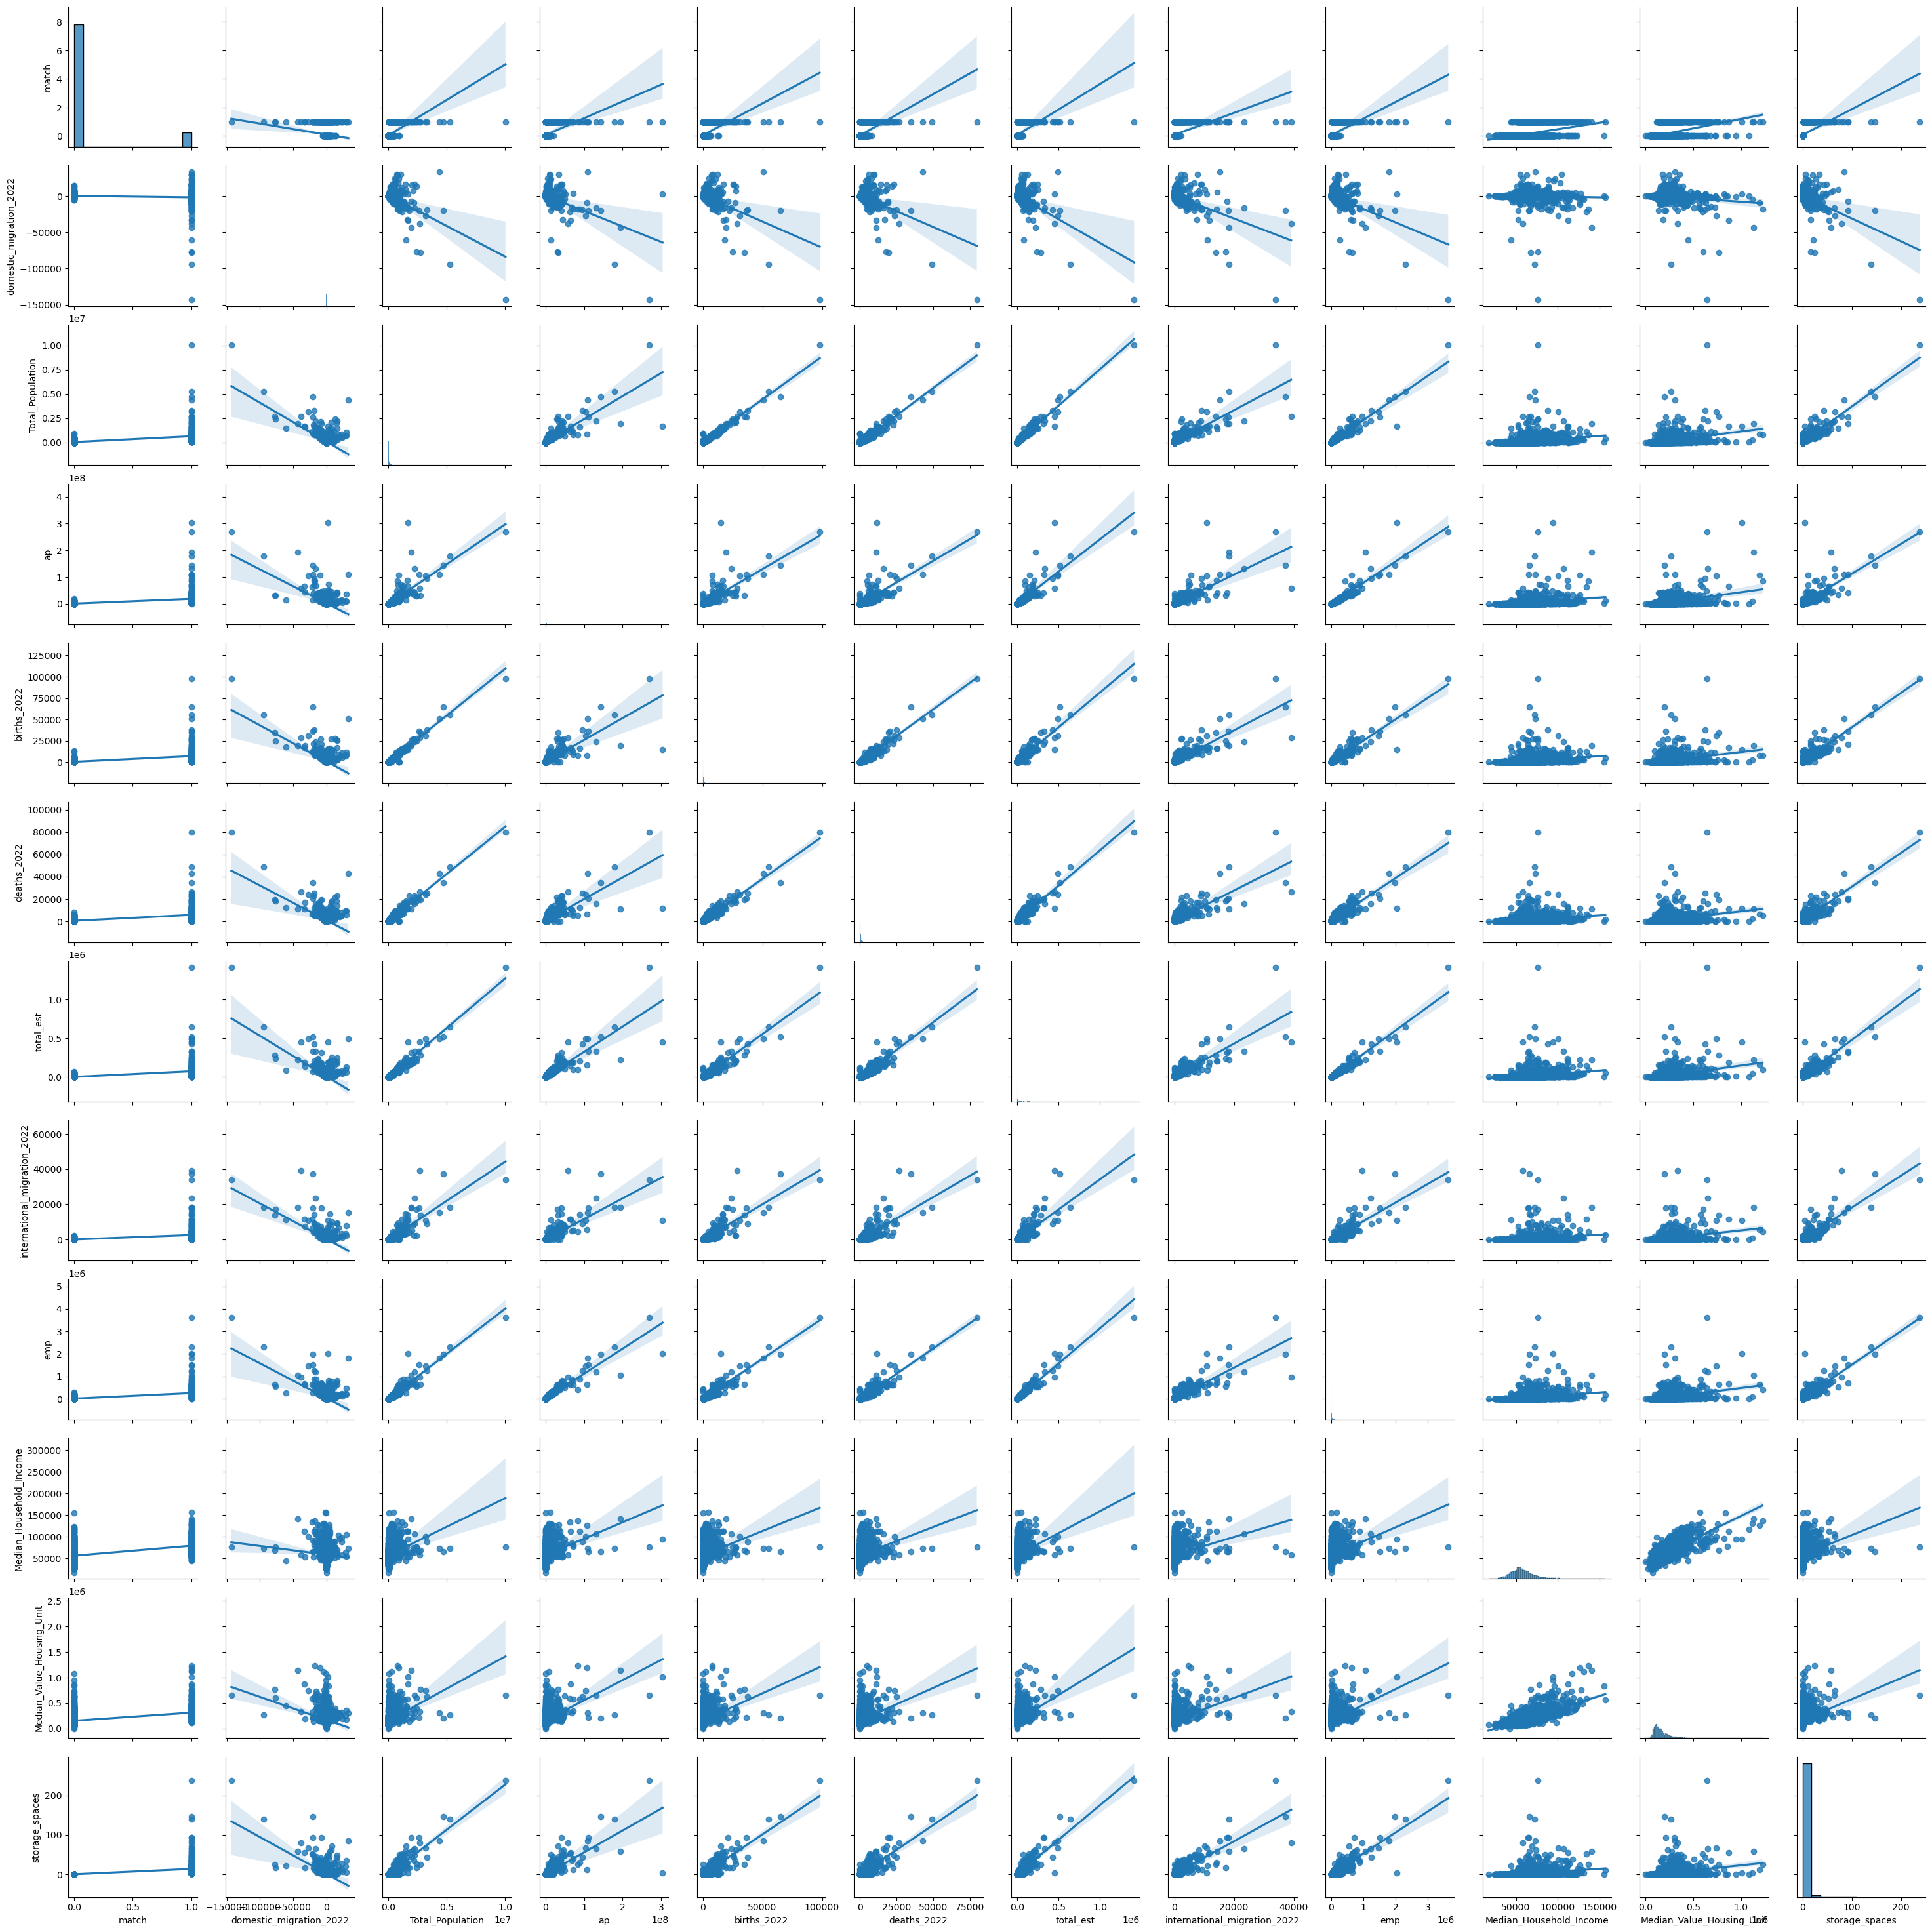

In [49]:
sns.pairplot(modeling_df, kind='reg')

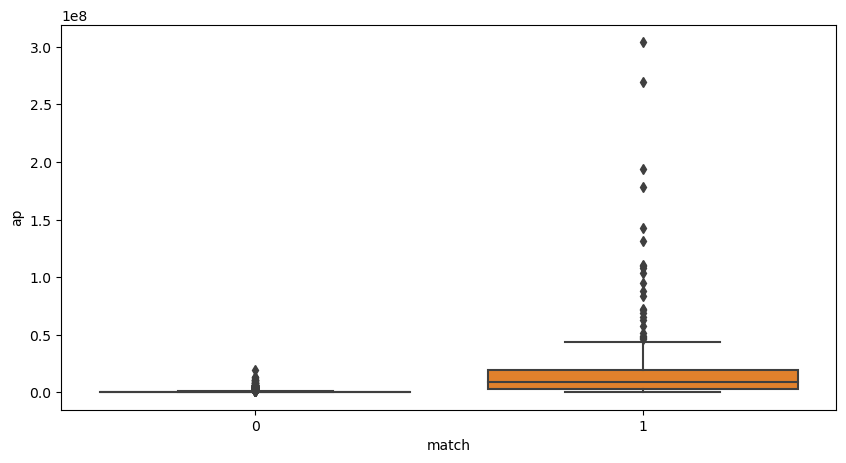

In [58]:
# Plot Annual Payroll conditioned on match
plt.figure(figsize=(10,5))
sns.boxplot(x='match', y='ap', data=modeling_df)
plt.show()

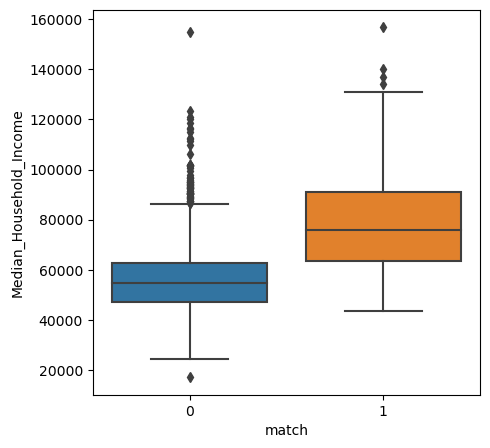

In [50]:
# Plot Annual Payroll conditioned on match
plt.figure(figsize=(5,5))
sns.boxplot(x='match', y='Median_Household_Income', data=modeling_df)
plt.show()

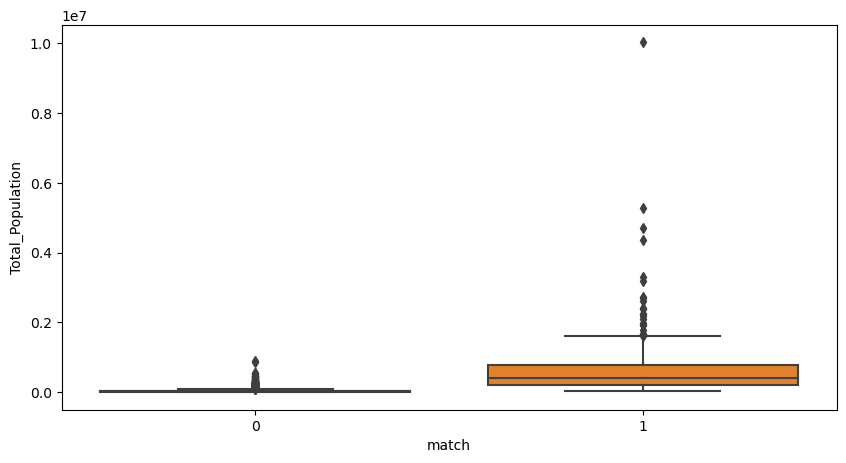

In [51]:
# Plot Population conditioned on match
plt.figure(figsize=(10,5))
sns.boxplot(x='match', y='Total_Population', data=modeling_df)
plt.show()

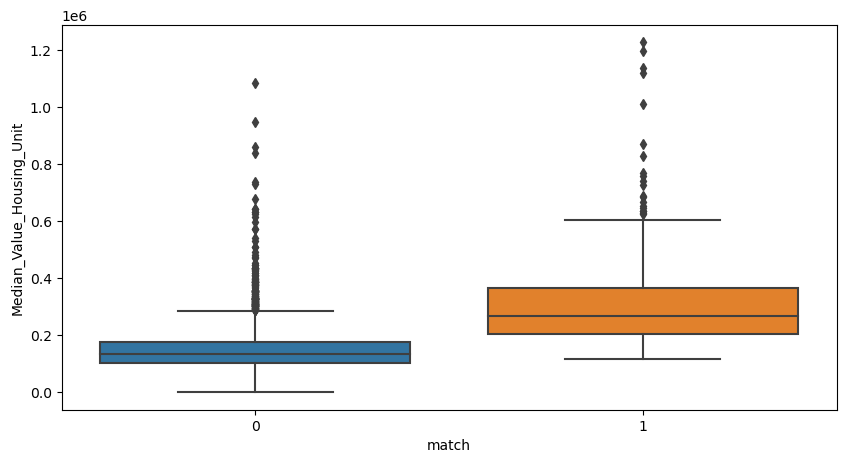

In [52]:
# Plot Median_Value_Housing_Unit conditioned on match
plt.figure(figsize=(10,5))
sns.boxplot(x='match', y='Median_Value_Housing_Unit', data=modeling_df)
plt.show()

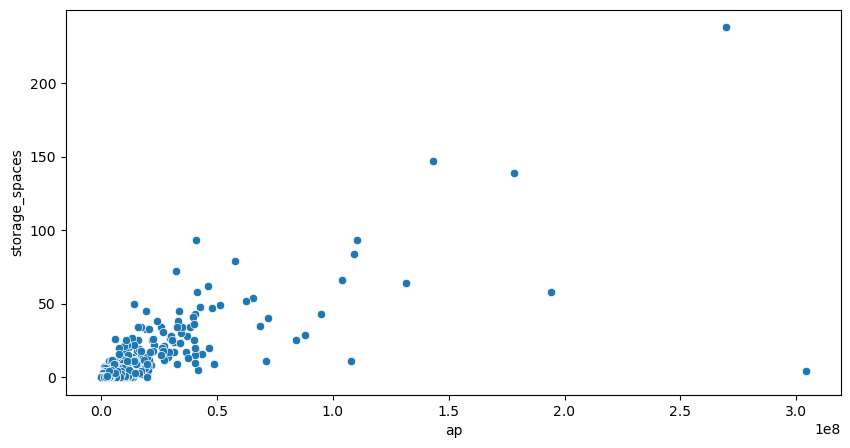

In [53]:
# Plot storage spaces against population
plt.figure(figsize=(10,5))
sns.scatterplot(x='ap', y='storage_spaces', data=modeling_df)
plt.show()

# Exploring Models

Prepare dataset for a logistic regression model. Dropping storage spaces column. Will use match binary field as an indication of counties with a storage space vs counties that don't have a storage space

In [54]:
final_modeling_df = modeling_df.copy()
final_modeling_df.drop(columns=['storage_spaces','county_fips'],inplace=True)

In [55]:
# Define X and Y variables. Define X for all columns except match
X = final_modeling_df.drop(columns=['match'],axis=1)
y = final_modeling_df['match']

In [56]:
modeling_df.county_fips.nunique()

3095

In [57]:
y.value_counts()

0    2769
1     326
Name: match, dtype: int64

In [58]:
# Build a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

model = LogisticRegression()

print(y_train.value_counts())
print(y_test.value_counts())

0    1951
1     215
Name: match, dtype: int64
0    818
1    111
Name: match, dtype: int64


In [63]:
# Define predictions 
predictions = model.predict(X_test)


In [64]:
model.fit(X_train,y_train)
print('Logistic Regression Accuracy Score: ',accuracy_score(y_test,predictions))
print('Logistic Regression Confusion Matrix: ',confusion_matrix(y_test,predictions))
print('Logistic Regression Classification Report: ',classification_report(y_test,predictions))

Logistic Regression Accuracy Score:  0.946178686759957
Logistic Regression Confusion Matrix:  [[807  11]
 [ 39  72]]
Logistic Regression Classification Report:                precision    recall  f1-score   support

           0       0.95      0.99      0.97       818
           1       0.87      0.65      0.74       111

    accuracy                           0.95       929
   macro avg       0.91      0.82      0.86       929
weighted avg       0.94      0.95      0.94       929



/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
X_test

,county_fips,domestic_migration_2022,Total_Population,ap,births_2022,deaths_2022,total_est,international_migration_2022,emp,Median_Household_Income,Median_Value_Housing_Unit
1383,27137,787,200311,4259468,1819,2495,23438,124,81575,61213,166900
1199,24013,1190,172148,2468080,1669,1785,18304,133,50736,104708,353500
1127,22027,-129,14456,91140,123,248,519,5,2175,29574,73300
2731,48415,-153,16985,232336,215,229,1161,18,4307,53376,94900
2385,46047,267,6979,170264,44,142,529,0,2510,51007,136400
...,...,...,...,...,...,...,...,...,...,...,...
1834,36011,-683,76644,792852,707,860,6154,40,17807,59602,138200
1840,36023,-337,46984,561358,457,502,3563,27,13269,62163,130000
2910,51187,401,40442,504290,453,463,3066,87,11574,72840,261100
447,13121,3362,1054286,71932905,12062,8193,187145,5097,811802,77635,345100


In [65]:
p_pred = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
score_ = model.score(X_test, y_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [66]:
predictions = model.predict(X_test)

In [67]:


# Build a random forest model
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100,criterion='gini',max_depth=10,random_state=101,bootstrap=True,n_jobs=16,max_features='auto',verbose=0,class_weight='balanced')
rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_test)

print('Random Forest Accuracy Score: ',accuracy_score(y_test,rfc_pred))
print('Random Forest Confusion Matrix: ',confusion_matrix(y_test,rfc_pred))
print('Random Forest Classification Report: ',classification_report(y_test,rfc_pred))

# Build a decision tree model
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

dtree_pred = dtree.predict(X_test)

print('Decision Tree Accuracy Score: ',accuracy_score(y_test,dtree_pred))
print('Decision Tree Confusion Matrix: ',confusion_matrix(y_test,dtree_pred))
print('Decision Tree Classification Report: ',classification_report(y_test,dtree_pred))


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Random Forest Accuracy Score:  0.9483315392895587
Random Forest Confusion Matrix:  [[797  21]
 [ 27  84]]
Random Forest Classification Report:                precision    recall  f1-score   support

           0       0.97      0.97      0.97       818
           1       0.80      0.76      0.78       111

    accuracy                           0.95       929
   macro avg       0.88      0.87      0.87       929
weighted avg       0.95      0.95      0.95       929

Decision Tree Accuracy Score:  0.9354144241119483
Decision Tree Confusion Matrix:  [[794  24]
 [ 36  75]]
Decision Tree Classification Report:                precision    recall  f1-score   support

           0       0.96      0.97      0.96       818
           1       0.76      0.68      0.71       111

    accuracy                           0.94       929
   macro avg       0.86      0.82      0.84       929
weighted avg       0.93      0.94      0.93       929



In [69]:
# Perform Grid Search to find the best parameters for Random Forest
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100,200,300,400,500],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth' : [4,5,6,7,8,10,12,14,16],
                'criterion' :['gini', 'entropy']}
grid = GridSearchCV(RandomForestClassifier(),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)

print('Best Parameters for Random Forest: ',grid.best_params_)
print('Best Estimator for Random Forest: ',grid.best_estimator_)
print('Best Score for Random Forest: ',grid.best_score_)
print('Best Index for Random Forest: ',grid.best_index_)
print('Scorer for Random Forest: ',grid.scorer_)
print('CV Results for Random Forest: ',grid.cv_results_)
print('CV Results for Random Forest: ',grid.cv_results_['mean_test_score'])


Fitting 5 folds for each of 270 candidates, totalling 1350 fits
[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.945 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.961 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.956 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.961 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=100;, score=0.961 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.942 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.952 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.956 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.961 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.961 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.942 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.956 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.961 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=300;, score=0.961 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=400;, score=0.942 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=400;, score=0.958 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=400;, score=0.961 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=400;, score=0.961 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=400;, score=0.961 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.942 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.954 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.961 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.961 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.963 total time=   0.9s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.940 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.942 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.956 total time=   0.4s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.963 total time=   0.3s
[

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.956 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.961 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=100;, score=0.961 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.940 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.958 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.965 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.965 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=200;, score=0.961 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=0.945 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=0.958 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=0.963 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400;, score=0.942 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400;, score=0.958 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400;, score=0.961 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=400;, score=0.961 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=500;, score=0.942 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=500;, score=0.958 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=500;, score=0.963 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=500;, score=0.968 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=5, max_features=auto, n_estimators=500;, score=0.965 total time=   0.9s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.945 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.961 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.956 total time=   0.4s
[CV 3/5] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.963 total time=   0.4s
[

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.945 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.961 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.968 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.945 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.958 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.961 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.968 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=200;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.945 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.954 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.968 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=300;, score=0.961 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=400;, score=0.945 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=400;, score=0.956 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=400;, score=0.965 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=400;, score=0.963 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=400;, score=0.963 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=500;, score=0.942 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=500;, score=0.958 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=500;, score=0.965 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=500;, score=0.965 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=6, max_features=auto, n_estimators=500;, score=0.963 total time=   1.2s
[CV 1/5] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.940 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=200;, score=0.961 total time=   0.4s
[CV 3/5] END criterion=gini, max_depth=6, max_features=sqrt, n_estimators=200;, score=0.963 total time=   0.5s
[

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=100;, score=0.945 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=100;, score=0.954 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=100;, score=0.956 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=100;, score=0.965 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200;, score=0.945 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200;, score=0.958 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200;, score=0.961 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=200;, score=0.965 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=0.945 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=0.954 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=400;, score=0.945 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=400;, score=0.954 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=400;, score=0.965 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=400;, score=0.963 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=400;, score=0.963 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500;, score=0.945 total time=   1.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500;, score=0.956 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500;, score=0.963 total time=   1.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500;, score=0.963 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=7, max_features=auto, n_estimators=500;, score=0.963 total time=   1.2s
[CV 1/5] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.940 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=200;, score=0.954 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=7, max_features=sqrt, n_estimators=200;, score=0.961 total time=   0.5s
[

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.938 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.956 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.958 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.961 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=100;, score=0.961 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.945 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.956 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.958 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.942 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.952 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.961 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=300;, score=0.963 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=400;, score=0.945 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=400;, score=0.952 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=400;, score=0.963 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=400;, score=0.963 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=400;, score=0.965 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=500;, score=0.940 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=500;, score=0.954 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=500;, score=0.965 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=500;, score=0.965 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=8, max_features=auto, n_estimators=500;, score=0.963 total time=   1.1s
[CV 1/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.942 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.952 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=200;, score=0.940 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=200;, score=0.956 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=8, max_features=sqrt, n_estimators=200;, score=0.965 total time=   0.5s
[

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100;, score=0.942 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100;, score=0.945 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100;, score=0.968 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=100;, score=0.961 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200;, score=0.942 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200;, score=0.952 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200;, score=0.956 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200;, score=0.968 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=200;, score=0.965 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=300;, score=0.942 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=300;, score=0.952 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=300;, score=0.958 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=300;, score=0.963 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=400;, score=0.945 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=400;, score=0.954 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=400;, score=0.961 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=400;, score=0.963 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=400;, score=0.963 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500;, score=0.945 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500;, score=0.952 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500;, score=0.963 total time=   1.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500;, score=0.965 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=10, max_features=auto, n_estimators=500;, score=0.963 total time=   1.2s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.938 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.961 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.952 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.961 total time=

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=100;, score=0.945 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=100;, score=0.954 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=100;, score=0.956 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=100;, score=0.968 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=100;, score=0.965 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=200;, score=0.945 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=200;, score=0.954 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=200;, score=0.961 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=300;, score=0.942 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=300;, score=0.954 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=300;, score=0.961 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=300;, score=0.963 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=400;, score=0.945 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=400;, score=0.954 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=400;, score=0.963 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=400;, score=0.965 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=400;, score=0.961 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=500;, score=0.940 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=500;, score=0.956 total time=   1.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=500;, score=0.958 total time=   1.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=500;, score=0.965 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=12, max_features=auto, n_estimators=500;, score=0.963 total time=   1.3s
[CV 1/5] END criterion=gini, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.940 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.954 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=12, max_features=sqrt, n_estimators=200;, score=0.938 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=12, max_features=sqrt, n_estimators=200;, score=0.949 total time=   0.4s
[CV 3/5] END criterion=gini, max_depth=12, max_features=sqrt, n_estimators=200;, score=0.961 total time=

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=100;, score=0.942 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=100;, score=0.949 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=100;, score=0.963 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=100;, score=0.963 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=100;, score=0.965 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=200;, score=0.945 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=200;, score=0.956 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=200;, score=0.958 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=200;, score=0.965 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=300;, score=0.945 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=300;, score=0.954 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=300;, score=0.958 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=300;, score=0.963 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=400;, score=0.942 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=400;, score=0.954 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=400;, score=0.961 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=400;, score=0.965 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=400;, score=0.961 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=500;, score=0.945 total time=   1.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=500;, score=0.956 total time=   1.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=500;, score=0.961 total time=   1.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=500;, score=0.965 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=14, max_features=auto, n_estimators=500;, score=0.961 total time=   1.2s
[CV 1/5] END criterion=gini, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.942 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.961 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=14, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=14, max_features=sqrt, n_estimators=200;, score=0.954 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=14, max_features=sqrt, n_estimators=200;, score=0.963 total time=

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=100;, score=0.947 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=100;, score=0.956 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=100;, score=0.961 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=100;, score=0.965 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=100;, score=0.963 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=200;, score=0.942 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=200;, score=0.952 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=200;, score=0.958 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=200;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=200;, score=0.963 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=300;, score=0.945 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=300;, score=0.956 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=300;, score=0.961 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=300;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=300;, score=0.963 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=400;, score=0.942 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=400;, score=0.954 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=400;, score=0.961 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=400;, score=0.968 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=400;, score=0.963 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=500;, score=0.945 total time=   1.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=500;, score=0.952 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=500;, score=0.958 total time=   1.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=500;, score=0.965 total time=   1.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=gini, max_depth=16, max_features=auto, n_estimators=500;, score=0.965 total time=   1.3s
[CV 1/5] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.947 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.954 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=200;, score=0.942 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=200;, score=0.956 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=16, max_features=sqrt, n_estimators=200;, score=0.961 total time=

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.942 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.956 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.956 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.958 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=100;, score=0.958 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.945 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.956 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.958 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.961 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=200;, score=0.961 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.942 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.954 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.958 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.961 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=300;, score=0.958 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=400;, score=0.942 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=400;, score=0.956 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=400;, score=0.958 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=400;, score=0.958 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=400;, score=0.961 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500;, score=0.947 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500;, score=0.956 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500;, score=0.961 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500;, score=0.961 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=4, max_features=auto, n_estimators=500;, score=0.961 total time=   1.1s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.942 total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.954 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.968 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=100;, score=0.961 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.942 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.956 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=4, max_features=sqrt, n_estimators=200;, score

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.947 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.958 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.961 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200;, score=0.945 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200;, score=0.956 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200;, score=0.963 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=200;, score=0.961 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=0.942 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=0.956 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=0.961 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=0.963 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=300;, score=0.961 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=400;, score=0.942 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=400;, score=0.956 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=400;, score=0.963 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=400;, score=0.963 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=400;, score=0.961 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=500;, score=0.945 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=500;, score=0.958 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=500;, score=0.963 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=500;, score=0.963 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=5, max_features=auto, n_estimators=500;, score=0.961 total time=   1.1s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.945 total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.954 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.961 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.3s
[CV 1/5] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.5s
[CV 2/5] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=200;, score=0.956 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=5, max_features=sqrt, n_estimators=200;, score

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.945 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.956 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.942 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.958 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.965 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.963 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=200;, score=0.963 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.945 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.956 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.963 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=400;, score=0.942 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=400;, score=0.956 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=400;, score=0.963 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=400;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=400;, score=0.963 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=500;, score=0.942 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=500;, score=0.956 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=500;, score=0.965 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=500;, score=0.965 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=6, max_features=auto, n_estimators=500;, score=0.965 total time=   1.0s
[CV 1/5] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.947 total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.961 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=200;, score=0.947 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=200;, score=0.956 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=200;, score

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=100;, score=0.945 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=100;, score=0.954 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=200;, score=0.945 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=200;, score=0.954 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=200;, score=0.965 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=200;, score=0.961 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=200;, score=0.965 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=0.942 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=0.954 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=0.963 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=400;, score=0.945 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=400;, score=0.956 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=400;, score=0.965 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=400;, score=0.963 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=400;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=500;, score=0.945 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=500;, score=0.952 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=500;, score=0.965 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=500;, score=0.963 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=7, max_features=auto, n_estimators=500;, score=0.965 total time=   1.1s
[CV 1/5] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.940 total time=   0.3s
[CV 2/5] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=200;, score=0.952 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=7, max_features=sqrt, n_estimators=200;, score

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.942 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.954 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=100;, score=0.965 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.945 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.954 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.965 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.963 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=200;, score=0.961 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.945 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.954 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=400;, score=0.942 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=400;, score=0.958 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=400;, score=0.963 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=400;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=400;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=500;, score=0.945 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=500;, score=0.954 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=500;, score=0.965 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=500;, score=0.963 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=8, max_features=auto, n_estimators=500;, score=0.963 total time=   1.1s
[CV 1/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.945 total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.954 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200;, score=0.954 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200;, score

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100;, score=0.947 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100;, score=0.952 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200;, score=0.945 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200;, score=0.954 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200;, score=0.961 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=200;, score=0.963 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=300;, score=0.945 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=300;, score=0.952 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=300;, score=0.963 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=400;, score=0.945 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=400;, score=0.956 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=400;, score=0.961 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=400;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=400;, score=0.963 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=500;, score=0.945 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=500;, score=0.947 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=500;, score=0.965 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=500;, score=0.958 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=10, max_features=auto, n_estimators=500;, score=0.963 total time=   1.1s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.945 total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.952 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.3s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.938 total time=   0.5s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=200;, score=0.954 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=20

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=100;, score=0.942 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=100;, score=0.952 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=100;, score=0.956 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=200;, score=0.945 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=200;, score=0.949 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=200;, score=0.963 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=200;, score=0.965 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=300;, score=0.945 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=300;, score=0.952 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=300;, score=0.963 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=300;, score=0.965 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=300;, score=0.961 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=400;, score=0.940 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=400;, score=0.954 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=400;, score=0.965 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=400;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=400;, score=0.963 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=500;, score=0.942 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=500;, score=0.952 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=500;, score=0.963 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=500;, score=0.963 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=12, max_features=auto, n_estimators=500;, score=0.963 total time=   1.1s
[CV 1/5] END criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.947 total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=200;, score=0.947 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=200;, score=0.952 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=12, max_features=sqrt, n_estimators=20

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=100;, score=0.947 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=100;, score=0.958 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=100;, score=0.958 total time=   0.3s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=100;, score=0.968 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=200;, score=0.945 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=200;, score=0.952 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=200;, score=0.965 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=200;, score=0.965 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=200;, score=0.961 total time=   0.5s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=300;, score=0.945 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=300;, score=0.952 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=300;, score=0.958 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=300;, score=0.963 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=300;, score=0.965 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=400;, score=0.949 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=400;, score=0.952 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=400;, score=0.965 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=400;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=400;, score=0.965 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=500;, score=0.947 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=500;, score=0.952 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=500;, score=0.965 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=500;, score=0.965 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=14, max_features=auto, n_estimators=500;, score=0.965 total time=   1.1s
[CV 1/5] END criterion=entropy, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.945 total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.949 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.958 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.970 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=14, max_features=sqrt, n_estimators=100;, score=0.963 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=14, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=14, max_features=sqrt, n_estimators=200;, score=0.949 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=14, max_features=sqrt, n_estimators=20

/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=100;, score=0.945 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=100;, score=0.949 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=100;, score=0.965 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=100;, score=0.963 total time=   0.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=200;, score=0.947 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=200;, score=0.952 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=200;, score=0.956 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=200;, score=0.968 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=200;, score=0.963 total time=   0.4s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=300;, score=0.952 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=300;, score=0.956 total time=   0.6s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=300;, score=0.963 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=300;, score=0.963 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=300;, score=0.965 total time=   0.7s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=400;, score=0.942 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=400;, score=0.954 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=400;, score=0.961 total time=   0.9s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=400;, score=0.965 total time=   0.8s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=400;, score=0.963 total time=   1.0s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 1/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=500;, score=0.945 total time=   1.2s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 2/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=500;, score=0.952 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 3/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=500;, score=0.961 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 4/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=500;, score=0.968 total time=   1.1s


/home/hamas/anaconda3/envs/intuitive_bayes/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[CV 5/5] END criterion=entropy, max_depth=16, max_features=auto, n_estimators=500;, score=0.963 total time=   1.2s
[CV 1/5] END criterion=entropy, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.942 total time=   0.2s
[CV 2/5] END criterion=entropy, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.961 total time=   0.2s
[CV 3/5] END criterion=entropy, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.956 total time=   0.2s
[CV 4/5] END criterion=entropy, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.961 total time=   0.2s
[CV 5/5] END criterion=entropy, max_depth=16, max_features=sqrt, n_estimators=100;, score=0.965 total time=   0.2s
[CV 1/5] END criterion=entropy, max_depth=16, max_features=sqrt, n_estimators=200;, score=0.945 total time=   0.4s
[CV 2/5] END criterion=entropy, max_depth=16, max_features=sqrt, n_estimators=200;, score=0.952 total time=   0.4s
[CV 3/5] END criterion=entropy, max_depth=16, max_features=sqrt, n_estimators=20

In [77]:
print('Best Parameters for Random Forest: ',grid.best_params_)
print('Best Estimator for Random Forest: ',grid.best_estimator_)
print('Best Score for Random Forest: ',grid.best_score_)
print('Best Index for Random Forest: ',grid.best_index_)
print('Scorer for Random Forest: ',grid.scorer_)
print('CV Results for Random Forest: ',grid.cv_results_)
print('CV Results for Random Forest: ',grid.cv_results_['mean_test_score'])


Best Parameters for Random Forest:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 400}
Best Estimator for Random Forest:  RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=400)
Best Score for Random Forest:  0.9598407850065455
Best Index for Random Forest:  43
Scorer for Random Forest:  <function _passthrough_scorer at 0x7f00e248d630>
CV Results for Random Forest:  {'mean_fit_time': array([0.16464911, 0.33255095, 0.49941235, 0.66745939, 0.84659772,
       0.18038359, 0.32750311, 0.48144217, 0.64612064, 0.80385509,
       0.15804744, 0.31865306, 0.49056454, 0.64930558, 0.82689137,
       0.18844485, 0.38001242, 0.56966658, 0.75994658, 0.91051059,
       0.18057828, 0.39147401, 0.57015324, 0.71143026, 0.88329535,
       0.18795762, 0.35981503, 0.54513073, 0.70034142, 0.88816214,
       0.19882717, 0.52748652, 0.77284408, 1.0170517 , 1.12713175,
       0.22840681, 0.42514505, 0.63890233, 0.85420876, 1.13149385,
       0.24369597, 0.45711

In [85]:
# Analyze the feature importance
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                      index = X_train.columns,
                                        columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
Total_Population,0.25
total_est,0.17
ap,0.13
international_migration_2022,0.13
emp,0.11
births_2022,0.10
deaths_2022,0.03
Median_Value_Housing_Unit,0.03
Median_Household_Income,0.03
domestic_migration_2022,0.02


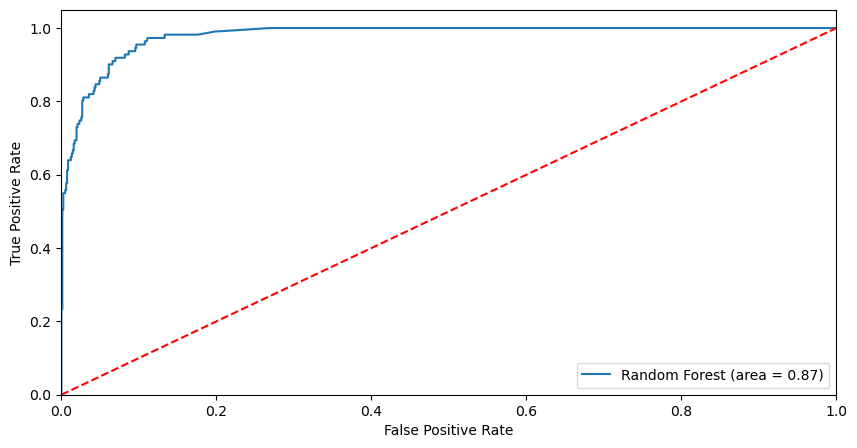

In [78]:
# Random Forest
rfc_roc_auc = roc_auc_score(y_test, rfc.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
plt.figure(figsize=(10,5))
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rfc_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [80]:
# Build a KNN model
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

print('KNN Accuracy Score: ',accuracy_score(y_test,knn_pred))
print('KNN Confusion Matrix: ',confusion_matrix(y_test,knn_pred))
print('KNN Classification Report: ',classification_report(y_test,knn_pred))

# Build a SVM model
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

svc_pred = svc.predict(X_test)

print('SVM Accuracy Score: ',accuracy_score(y_test,svc_pred))
print('SVM Confusion Matrix: ',confusion_matrix(y_test,svc_pred))
print('SVM Classification Report: ',classification_report(y_test,svc_pred))

# Build a Naive Bayes model
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

nb.fit(X_train, y_train)

nb_pred = nb.predict(X_test)

print('Naive Bayes Accuracy Score: ',accuracy_score(y_test,nb_pred))
print('Naive Bayes Confusion Matrix: ',confusion_matrix(y_test,nb_pred))
print('Naive Bayes Classification Report: ',classification_report(y_test,nb_pred))

# Build a XGBoost model
from xgboost import XGBClassifier

xgb = XGBClassifier()

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

print('XGBoost Accuracy Score: ',accuracy_score(y_test,xgb_pred))
print('XGBoost Confusion Matrix: ',confusion_matrix(y_test,xgb_pred))
print('XGBoost Classification Report: ',classification_report(y_test,xgb_pred))



KNN Accuracy Score:  0.9311087190527448
KNN Confusion Matrix:  [[788  30]
 [ 34  77]]
KNN Classification Report:                precision    recall  f1-score   support

           0       0.96      0.96      0.96       818
           1       0.72      0.69      0.71       111

    accuracy                           0.93       929
   macro avg       0.84      0.83      0.83       929
weighted avg       0.93      0.93      0.93       929

SVM Accuracy Score:  0.9407965554359526
SVM Confusion Matrix:  [[812   6]
 [ 49  62]]
SVM Classification Report:                precision    recall  f1-score   support

           0       0.94      0.99      0.97       818
           1       0.91      0.56      0.69       111

    accuracy                           0.94       929
   macro avg       0.93      0.78      0.83       929
weighted avg       0.94      0.94      0.93       929

Naive Bayes Accuracy Score:  0.9354144241119483
Naive Bayes Confusion Matrix:  [[787  31]
 [ 29  82]]
Naive Bayes Clas

https://www2.census.gov/programs-surveys/cbp/technical-documentation/records-layouts/2018_record_layouts/metro-area-layout-2018.txt